In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

import data

warnings.simplefilter(action='ignore', category=FutureWarning)

# Read & Process

## Read equities & cryptocurrencies data

In [2]:
df_equity = data.read_excel_sheets()
df_equity['OpenTime'] = pd.to_datetime(df_equity['OpenTime'])
df_equity = df_equity.set_index('OpenTime') 

list_equity = df_equity.Symbol.unique().tolist()
print(f"\nEquity:\n{list_equity}")

crypto = 'data_crypto.xlsx'
df_crypto = (
    pd.read_excel(crypto)
    .drop(columns=['Unnamed: 0'])
)

df_crypto['OpenTime'] = pd.to_datetime(df_crypto['OpenTime'])
df_crypto = df_crypto.set_index('OpenTime') 

list_crypto = df_crypto.Symbol.unique().tolist()
print(f"\nCrypto:\n{list_crypto}")

AAPL
MSFT
NVDA
AMZN
META
GOOGL
BRK.B
GOOG
AVGO
TSLA
SPY_ETF
DAXEX_ETF
CAC40_ETF
NKY225_ETF
DJIA_ETF
EQQQ_ETF
FTSE_ETF

Equity:
['NKY225_ETF', 'AAPL', 'AMZN', 'AVGO', 'BRK.B', 'DJIA_ETF', 'GOOG', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY_ETF', 'TSLA', 'DAXEX_ETF', 'CAC40_ETF', 'EQQQ_ETF', 'FTSE_ETF']

Crypto:
['ADAUSDT', 'AVAXUSDT', 'BNBUSDT', 'BTCUSDT', 'DOGEUSDT', 'ETHUSDT', 'SOLUSDT', 'TRXUSDT', 'USDCUSDT', 'XRPUSDT']


# Pair Trading Example

## Prepare the pair trading series

In [4]:
ticker_eqt = 'DJIA_ETF'
ticker_cpy = 'BNBUSDT'

price_eqt = df_equity[df_equity['Symbol']==ticker_eqt]['Close'].rename(ticker_eqt)
t00 = price_eqt.index[0]

price_cpy = df_crypto[df_crypto['Symbol']==ticker_cpy]['Close'].rename(ticker_cpy)
t10 = price_cpy.index[0]

merged = pd.concat([price_eqt, price_cpy], axis=1)

if t00 > t10:
    t0 = t00
else:
    t0 = t10

merged = merged.loc[t0:].dropna()
merged

,DJIA_ETF,BNBUSDT
OpenTime,,
2024-10-14 12:30:00,427.88,590.50
2024-10-14 12:35:00,427.66,590.10
2024-10-14 12:40:00,427.92,589.30
2024-10-14 12:45:00,428.53,588.70
2024-10-14 12:50:00,428.00,588.30
...,...,...
2025-01-06 18:45:00,426.26,738.47
2025-01-06 18:50:00,426.57,738.72
2025-01-06 18:55:00,427.13,737.95


- Helper functions to create a Pandas datafram with 2 different series

In [5]:
def process_pairs_series(seriesX, seriesY, dfX, dfY):

    priceX = dfX[dfX['Symbol']==seriesX]['Close'].rename(seriesX)
    t00 = priceX.index[0]
    
    priceY = dfY[dfY['Symbol']==seriesY]['Close'].rename(seriesY)
    t10 = priceY.index[0]

    merged = pd.concat([priceX, priceY], axis=1)
    if t00 > t10:
        t0 = t00
    else:
        t0 = t10
    
    return merged.loc[t0:].dropna()

In [6]:
seriesX = 'NVDA'
seriesY = 'BNBUSDT'

price_pairs1 = process_pairs_series(seriesX, seriesY, df_equity, df_crypto)
price_pairs1

,NVDA,BNBUSDT
OpenTime,,
2024-10-14 12:30:00,137.9800,590.50
2024-10-14 12:35:00,138.0400,590.10
2024-10-14 12:40:00,137.6000,589.30
2024-10-14 12:45:00,138.1000,588.70
2024-10-14 12:50:00,138.6400,588.30
...,...,...
2025-01-06 18:35:00,149.9900,740.84
2025-01-06 18:40:00,149.8101,740.39
2025-01-06 18:45:00,148.8970,738.47


In [7]:
seriesX = 'DJIA_ETF'
seriesY = 'AVAXUSDT'

price_pairs2 = process_pairs_series(seriesX, seriesY, df_equity, df_crypto)
price_pairs2

,DJIA_ETF,AVAXUSDT
OpenTime,,
2024-10-14 12:30:00,427.88,29.37
2024-10-14 12:35:00,427.66,29.38
2024-10-14 12:40:00,427.92,29.32
2024-10-14 12:45:00,428.53,29.22
2024-10-14 12:50:00,428.00,29.13
...,...,...
2025-01-06 18:45:00,426.26,44.01
2025-01-06 18:50:00,426.57,43.99
2025-01-06 18:55:00,427.13,43.99


## Test for Augmented Dickey-Fuller (ADF), Cointegration & Correlation

In [9]:
priceX = price_pairs1.iloc[:, 0]
priceY = price_pairs1.iloc[:, 1]

coint_stat, p_value, crit_values = coint(priceX, priceY)

# Print the results
print("Cointegration Test Results:")
print(f"Test Statistic: {coint_stat:.4f}")
print(f"P-Value: {p_value:.4f}")
print(f"Critical Values (1%, 5%, 10%): {crit_values}")

Cointegration Test Results:
Test Statistic: -2.4685
P-Value: 0.2931
Critical Values (1%, 5%, 10%): [-3.89890003 -3.33750186 -3.04540215]


In [13]:
def run_cointegration_test(price_pairs, print_stats=False, plotting=False, std=2):

    priceX = price_pairs.iloc[:, 0]
    priceY = price_pairs.iloc[:, 1]
    
    tickerX = priceX.name
    tickerY = priceY.name

    model = sm.OLS(priceY, sm.add_constant(priceX)).fit()
    beta = model.params.iloc[1] #hedge ratio
    spread = priceY - beta * priceX
    # residuals = model.resid

    # correlation of both series
    correlation = priceX.corr(priceY)

    # ADF test for the Spread
    adf_result = adfuller(spread)
    
    # cointegration of both series
    coint_result = coint(priceX, priceY)
    
    if print_stats:
        print(f"Pairs: {tickerX} & {tickerY}")
        print(f"Correlation: {correlation:.3f}")

        adf_stat, adf_pv, _, num_observations, *_ = adf_result
        print(f"\nSpread ADF Statistic: {adf_stat:.4f}")
        if adf_pv < 0.05:
            print(f"p-value: {adf_pv:.3f} (Spread is stationary)")
        else:
            print(f"p-value: {adf_pv:.3f} (Spread is non-stationary)")

        coint_stat, coint_pv, crit_values = coint_result
        print(f"\nCointegration Test Statistic: {coint_stat:.4f}")
        if coint_pv < 0.05:
            print(f"p-value: {coint_pv:.3f} (Both series are cointegrated)")
        else:
            print(f"p-value: {coint_pv:.3f} (Both series are not cointegrated)")

    if plotting:
        # spreads computes
        spread_mean = spread.mean()
        spread_std = spread.std()
        z_score = (spread - spread_mean) / spread_std

        # Create a 1x3 subplot layout
        fig, axes = plt.subplots(1, 3, figsize=(21, 4))  # 1 row, 3 columns
        
        # Plot 1: Spread and Trading Thresholds
        axes[0].plot(spread, label='Spread')
        axes[0].axhline(spread_mean, color='red', linestyle='--', label='Mean')
        axes[0].axhline(spread_mean + std * spread_std, color='green', linestyle='--', label='Upper Threshold')
        axes[0].axhline(spread_mean - std * spread_std, color='green', linestyle='--', label='Lower Threshold')
        axes[0].set_title('Spread and Trading Thresholds')
        axes[0].legend()
        
        # Plot 2: Z-Score of Spread
        axes[1].plot(z_score, label='Z-Score')
        axes[1].axhline(std, color='green', linestyle='--', label='Upper Threshold')
        axes[1].axhline(-std, color='green', linestyle='--', label='Lower Threshold')
        axes[1].axhline(0, color='red', linestyle='--', label='Mean')
        axes[1].set_title('Z-Score of Spread')
        axes[1].legend()
        
        # Plot 3: Normalized Prices
        price_normalized = price_pairs / price_pairs.iloc[0]
        axes[2].plot(price_normalized[tickerX], label=f'{tickerX} (Normalized)', linestyle='-')
        axes[2].plot(price_normalized[tickerY], label=f'{tickerY} (Normalized)', linestyle='--')
        axes[2].set_title(f'Price Correlation of {tickerX} and {tickerY} (Normalized)')
        axes[2].set_xlabel('Time')
        axes[2].set_ylabel('Normalized Price')
        axes[2].legend()
        axes[2].grid(True)
        
        # Adjust layout for better display
        plt.tight_layout()
        plt.show()

    return spread, correlation, adf_result, coint_result


Pairs: NVDA & BNBUSDT
Correlation: -0.139

Spread ADF Statistic: -1.0149
p-value: 0.748 (Spread is non-stationary)

Cointegration Test Statistic: -2.4685
p-value: 0.293 (Both series are not cointegrated)


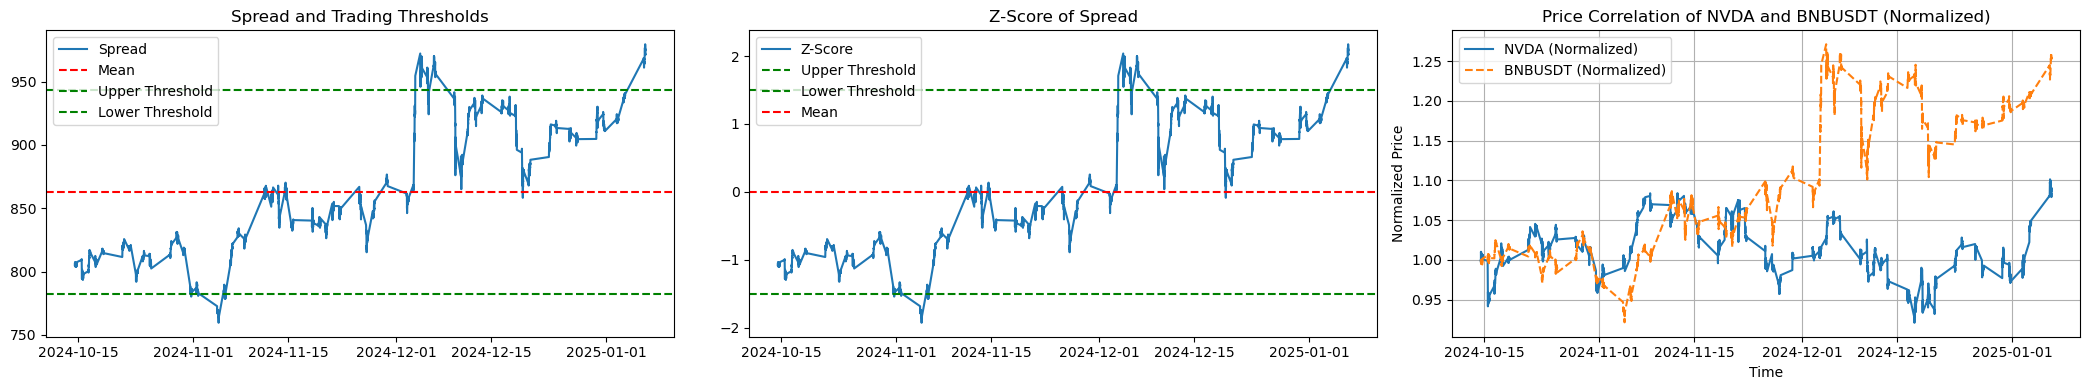

In [14]:
spread, correlation, adf_result, coint_result = run_cointegration_test(price_pairs1, print_stats=True, plotting=True, std=1.5)

Pairs: NVDA & BNBUSDT
Correlation: -0.139

Spread ADF Statistic: -1.0149
p-value: 0.748 (Spread is non-stationary)

Cointegration Test Statistic: -2.4685
p-value: 0.293 (Both series are not cointegrated)


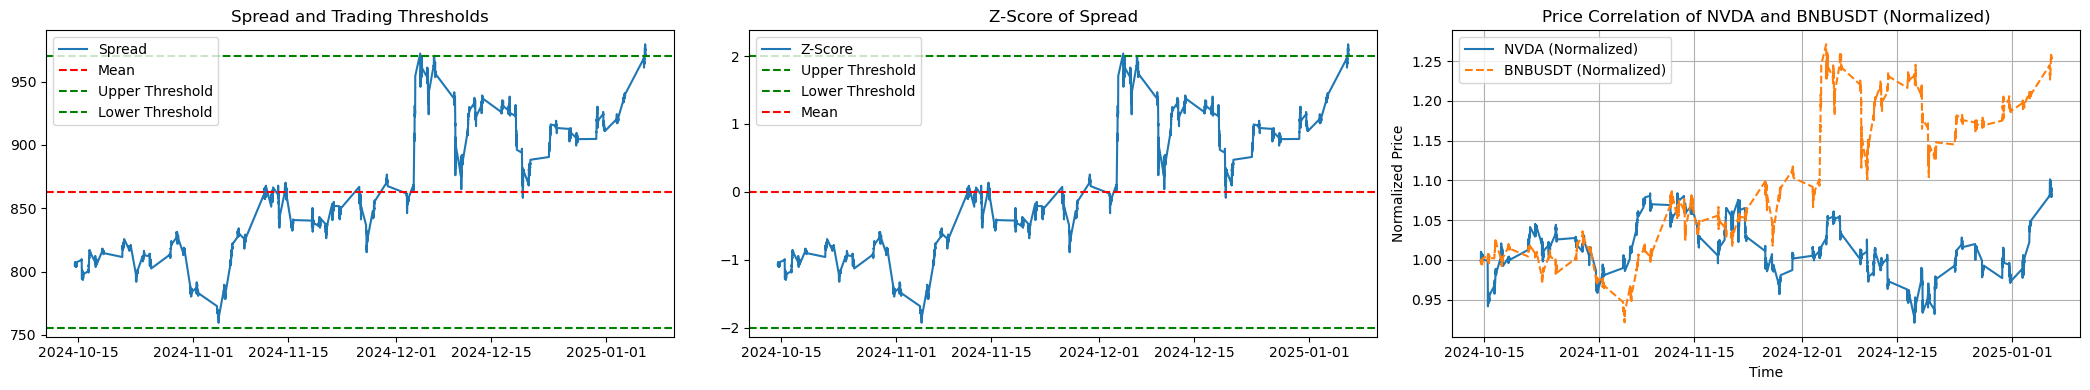

In [15]:
spread, correlation, adf_result, coint_result = run_cointegration_test(price_pairs1, print_stats=True, plotting=True, std=2)

Pairs: DJIA_ETF & AVAXUSDT
Correlation: 0.702

Spread ADF Statistic: -1.5913
p-value: 0.488 (Spread is non-stationary)

Cointegration Test Statistic: -1.9444
p-value: 0.557 (Both series are not cointegrated)


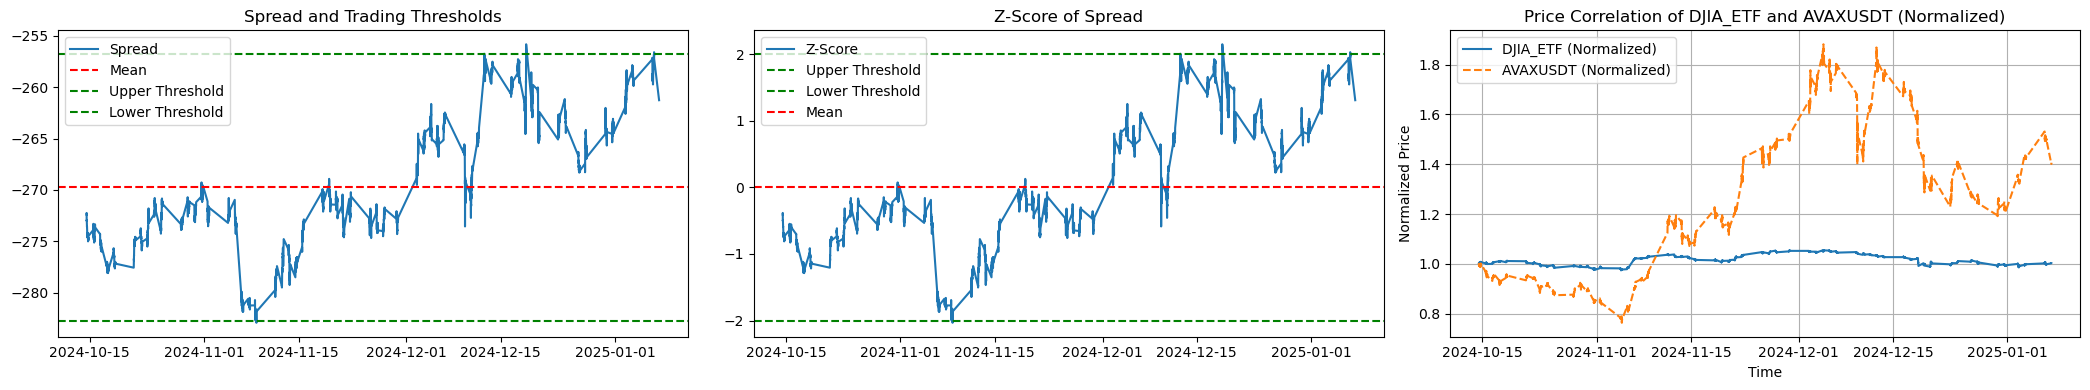

In [16]:
spread, correlation, adf_result, coint_result = run_cointegration_test(price_pairs2, print_stats=True, plotting=True)

In [17]:
spread, correlation, adf_result, coint_result

(OpenTime
 2024-10-14 12:30:00   -272.396314
 2024-10-14 12:35:00   -272.231157
 2024-10-14 12:40:00   -272.474524
 2024-10-14 12:45:00   -273.004732
 2024-10-14 12:50:00   -272.720945
                           ...    
 2025-01-06 18:45:00   -256.613794
 2025-01-06 18:50:00   -256.852424
 2025-01-06 18:55:00   -257.247369
 2025-01-07 12:30:00   -261.222836
 2025-01-07 12:35:00   -261.280309
 Length: 4464, dtype: float64,
 0.7023691792433548,
 (-1.5913028258833186,
  0.4879609190836383,
  12,
  4451,
  {'1%': -3.431820023656888,
   '5%': -2.8621895738638443,
   '10%': -2.5671157719825066},
  3463.7220785657128),
 (-1.9444346044248928,
  0.5573129002304549,
  array([-3.89889562, -3.3374994 , -3.04540044])))

In [18]:
%%time
i = 0
list_results = []

for ticker_eqt in list_equity:
    for ticket_cpy in list_crypto:   
        i += 1
        
        # Prepare for pair prices
        price_pairs = process_pairs_series(ticker_eqt, ticket_cpy, df_equity, df_crypto)
        spread, correlation, adf_result, coint_result = run_cointegration_test(price_pairs, print_stats=False, plotting=False)

        # Unpack adf result
        adf_stat, adf_pv, _, num_observations, *_ = adf_result

        # Check for Spread stationarity
        spread_stationary = adf_pv <= 0.05

        # Unpack cointegration result
        coint_stat, coint_pv, crit_values = coint_result

        # Check for Series cointegration
        series_coint = coint_pv <= 0.05

        # Store results
        list_results.append({
            "seriesX": ticker_eqt,
            "seriesY": ticket_cpy,
            "correlation": correlation,
            "spread_adf_stat": adf_stat,
            "spread_adf_pValue": adf_pv,
            "spread_stationary": spread_stationary,
            "series_coint_stat": coint_stat,
            "series_coint_pValue": coint_pv,
            "series_cointegrated": series_coint
        })

print(f"# of Equity-Crypto Pairs: {i}")

# of Equity-Crypto Pairs: 170
CPU times: user 1min 17s, sys: 36.4 s, total: 1min 53s
Wall time: 32.4 s


In [19]:
df_results = pd.DataFrame(list_results)
df_results.sample(5)

,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
119,SPY_ETF,XRPUSDT,0.716851,-1.895136,0.334353,False,-2.581129,0.244506,False
84,META,DOGEUSDT,0.384726,-2.026641,0.275016,False,-1.869186,0.595550,False
102,NVDA,BNBUSDT,-0.138888,-1.014871,0.747802,False,-2.468532,0.293121,False
66,GOOG,SOLUSDT,0.273915,-1.690041,0.436251,False,-0.823285,0.931574,False
83,META,BTCUSDT,0.516168,-2.252839,0.187629,False,-2.207789,0.420350,False


In [20]:
df_results.spread_stationary.value_counts(), df_results.series_cointegrated.value_counts()

(spread_stationary
 False    145
 True      25
 Name: count, dtype: int64,
 series_cointegrated
 False    166
 True       4
 Name: count, dtype: int64)

In [21]:
spread_stationary = True
series_cointegrated = True
correlation = 0.8

df_results[(df_results['spread_stationary']==spread_stationary) & (df_results['series_cointegrated']==series_cointegrated) & (df_results['correlation']>=correlation)]

,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
111,SPY_ETF,AVAXUSDT,0.872955,-3.231211,0.018248,True,-3.620874,0.023081,True
115,SPY_ETF,ETHUSDT,0.887785,-3.489125,0.008271,True,-3.761870,0.015227,True
152,EQQQ_ETF,BNBUSDT,0.888742,-4.288608,0.000465,True,-4.101710,0.005115,True


In [22]:
spread_stationary = True
series_cointegrated = True

df_results[(df_results['spread_stationary']==spread_stationary) & (df_results['series_cointegrated']==series_cointegrated)]

,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
82,META,BNBUSDT,0.786616,-3.338127,0.013258,True,-3.607567,0.023978,True
111,SPY_ETF,AVAXUSDT,0.872955,-3.231211,0.018248,True,-3.620874,0.023081,True
115,SPY_ETF,ETHUSDT,0.887785,-3.489125,0.008271,True,-3.761870,0.015227,True
152,EQQQ_ETF,BNBUSDT,0.888742,-4.288608,0.000465,True,-4.101710,0.005115,True


In [23]:
spread_stationary = True
# series_cointegrated = True

df_results[(df_results['spread_stationary']==spread_stationary) & (df_results['correlation']>=0.75)]

,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
82,META,BNBUSDT,0.786616,-3.338127,0.013258,True,-3.607567,0.023978,True
87,META,TRXUSDT,0.773627,-3.113414,0.025576,True,-3.186871,0.072151,False
111,SPY_ETF,AVAXUSDT,0.872955,-3.231211,0.018248,True,-3.620874,0.023081,True
114,SPY_ETF,DOGEUSDT,0.808857,-2.869297,0.049037,True,-3.155951,0.077608,False
115,SPY_ETF,ETHUSDT,0.887785,-3.489125,0.008271,True,-3.761870,0.015227,True
132,DAXEX_ETF,BNBUSDT,0.869679,-3.713021,0.003934,True,-3.318553,0.052236,False
137,DAXEX_ETF,TRXUSDT,0.880796,-3.416370,0.010413,True,-3.088978,0.090538,False
152,EQQQ_ETF,BNBUSDT,0.888742,-4.288608,0.000465,True,-4.101710,0.005115,True


Pairs: META & BNBUSDT
Correlation: 0.787

Spread ADF Statistic: -3.3381
p-value: 0.013 (Spread is stationary)

Cointegration Test Statistic: -3.6076
p-value: 0.024 (Both series are cointegrated)


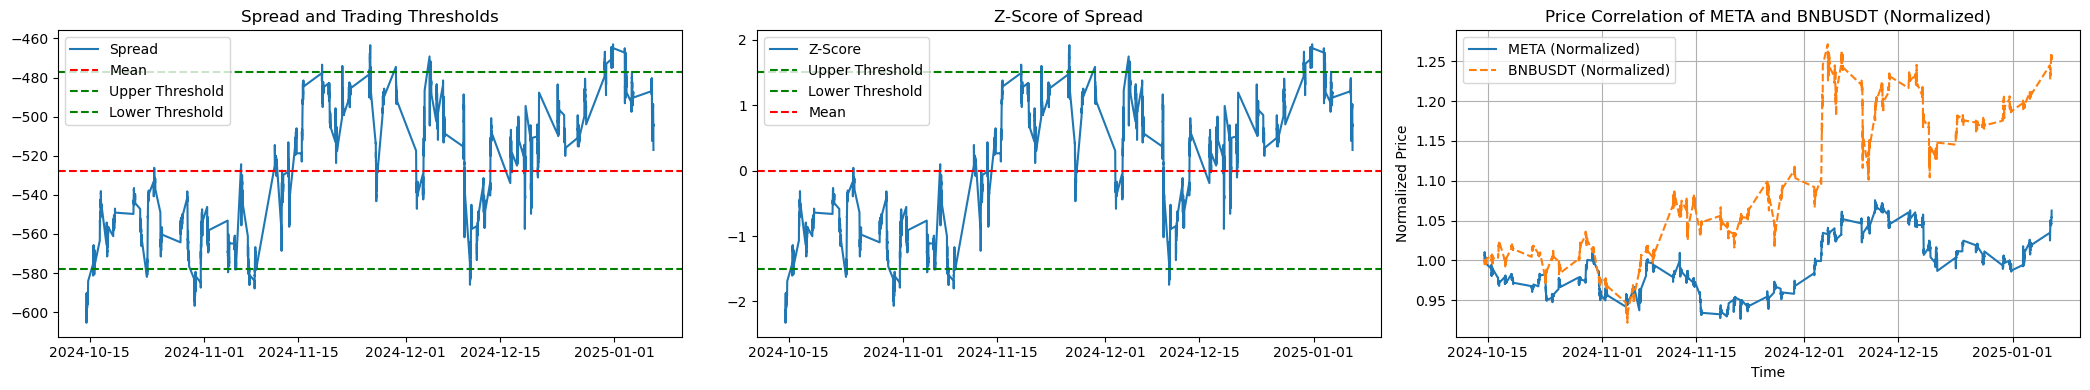

Pairs: SPY_ETF & AVAXUSDT
Correlation: 0.873

Spread ADF Statistic: -3.2312
p-value: 0.018 (Spread is stationary)

Cointegration Test Statistic: -3.6209
p-value: 0.023 (Both series are cointegrated)


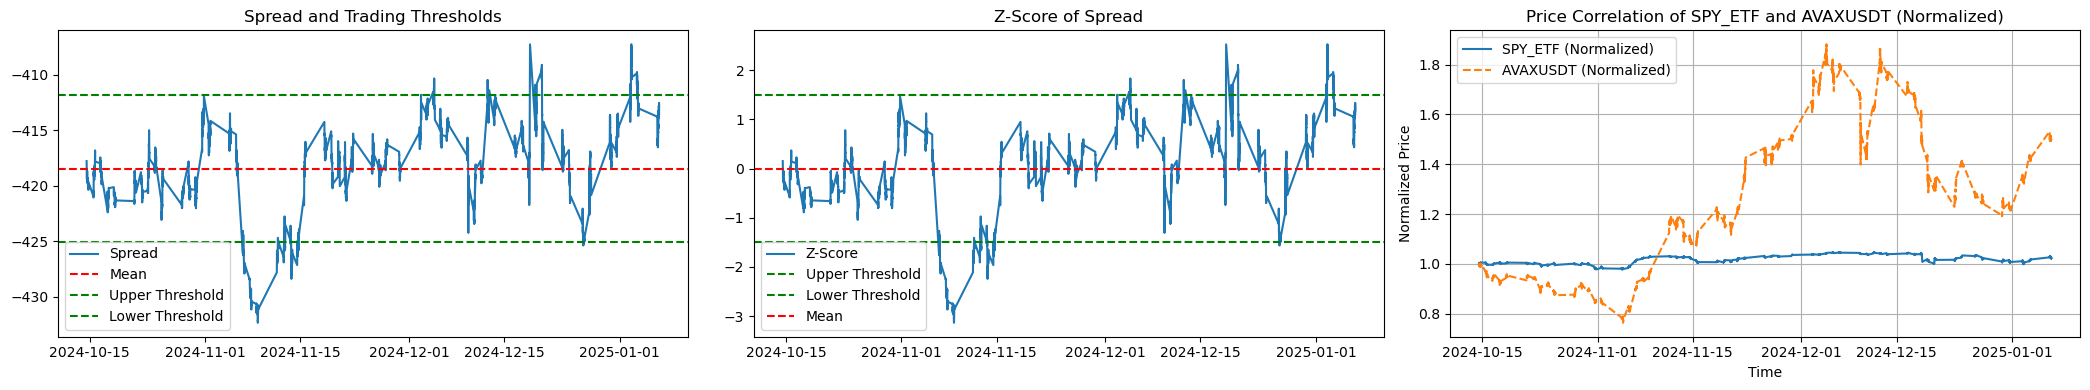

Pairs: SPY_ETF & ETHUSDT
Correlation: 0.888

Spread ADF Statistic: -3.4891
p-value: 0.008 (Spread is stationary)

Cointegration Test Statistic: -3.7619
p-value: 0.015 (Both series are cointegrated)


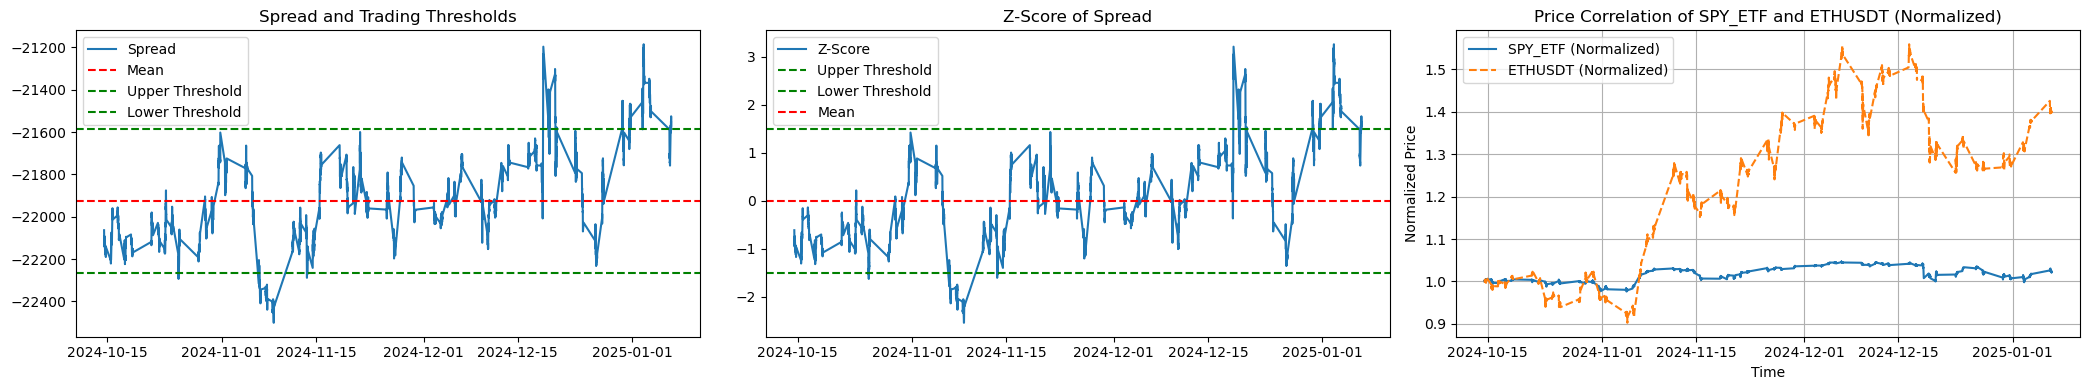

Pairs: EQQQ_ETF & BNBUSDT
Correlation: 0.889

Spread ADF Statistic: -4.2886
p-value: 0.000 (Spread is stationary)

Cointegration Test Statistic: -4.1017
p-value: 0.005 (Both series are cointegrated)


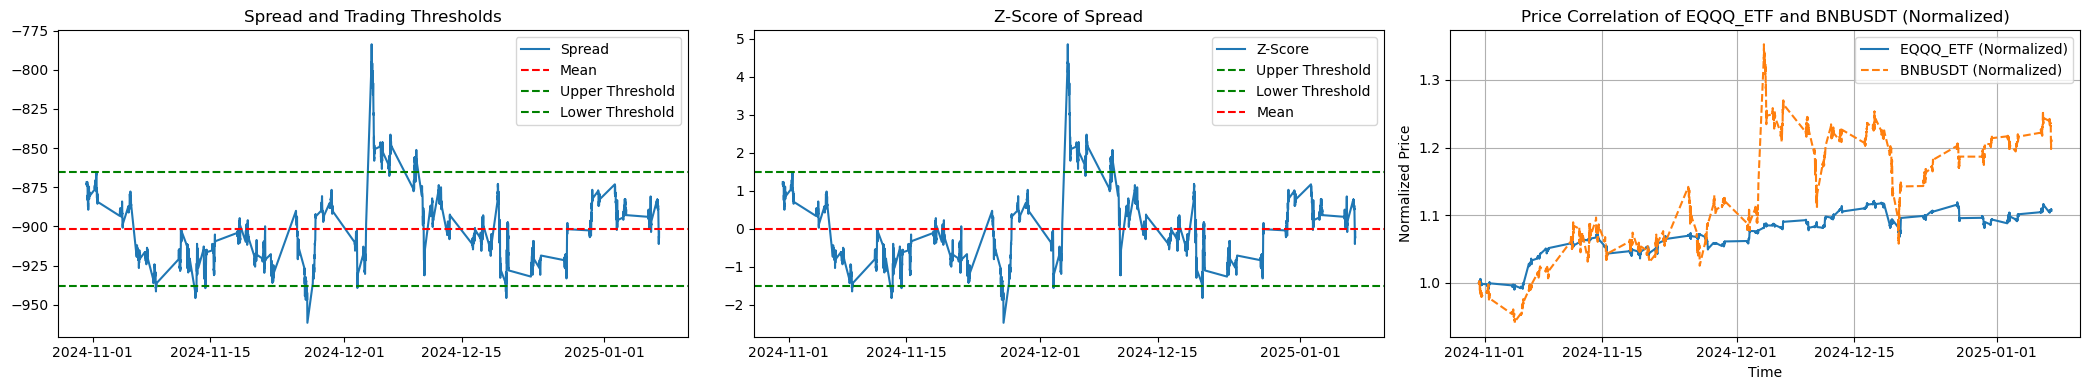

In [24]:
spread_stationary = True
series_cointegrated = True
filtered = df_results[(df_results['spread_stationary']==spread_stationary) & (df_results['series_cointegrated']==series_cointegrated)]

for i, r in filtered.iterrows():
    ticker_eqt = r['seriesX']
    ticket_cpy = r['seriesY']
    price_pairs = process_pairs_series(ticker_eqt, ticket_cpy, df_equity, df_crypto)
    spread, correlation, adf_result, coint_result = run_cointegration_test(price_pairs, print_stats=True, plotting=True, std=1.5)